# MoRu Phase Prediction using GPyTorch Gaussian Process Classifier

In [1]:
import math
import torch
import gpytorch
import numpy as np
from matplotlib import pyplot as plt

%matplotlib inline
%load_ext autoreload
%autoreload 2

##  Input Data

In [2]:
import json

filename = 'data/MoRu.json'
stream = open(filename)
data = json.load(stream)
stream.close()

In [4]:
temperature = np.zeros(len(data))
pressure = np.zeros(len(data))
mu_Mo = np.zeros(len(data))
mu_Ru = np.zeros(len(data))
Gibbs = np.zeros(len(data))
BCCN = np.zeros(len(data))
HCPN = np.zeros(len(data))
Liquid = np.zeros(len(data))

In [5]:
keys = list(data.keys())
for i in keys:
    temperature[keys.index(i)] = data[i]["temperature"]
    pressure[keys.index(i)] = data[i]["pressure"]
    mu_Mo[keys.index(i)] = data[i]["elements"]["Mo"]["element potential"]
    mu_Ru[keys.index(i)] = data[i]["elements"]["Ru"]["element potential"]
    Gibbs[keys.index(i)] = data[i]["integral Gibbs energy"]
    BCCN[keys.index(i)] = data[i]["solution phases"]["BCCN"]["moles"]
    HCPN[keys.index(i)] = data[i]["solution phases"]["HCPN"]["moles"]
    Liquid[keys.index(i)] = data[i]["solution phases"]["LiqN"]["moles"]

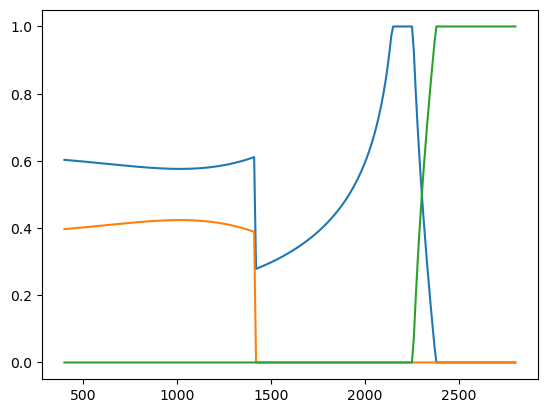

In [7]:
# plt.plot(temperature, mu_Mo)
# plt.plot(temperature, mu_Ru)
# plt.plot(temperature, Gibbs)
plt.plot(temperature, BCCN)
plt.plot(temperature, HCPN)
plt.plot(temperature, Liquid)
plt.show()

## Classification

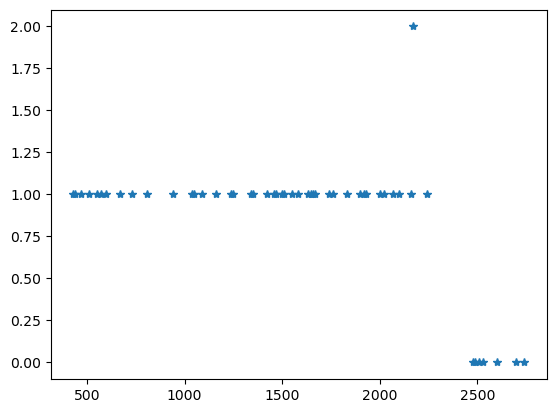

In [9]:
n_train = 50
train_x = torch.linspace(0,1,n_train)
train_y = torch.linspace(0,1,n_train)

rng = np.random.default_rng()
indices = np.sort(rng.choice(len(data), size=n_train, replace=False))

for i in range(n_train):
    train_x[i] = temperature[indices[i]]
    train_y[i] = np.ceil(BCCN[indices[i]])

plt.plot(train_x, train_y, '*')
plt.show()

In [10]:
from gpytorch.models import ApproximateGP
from gpytorch.variational import CholeskyVariationalDistribution
from gpytorch.variational import UnwhitenedVariationalStrategy
from gpytorch.variational import VariationalStrategy


class GPClassificationModel(ApproximateGP):
    def __init__(self, train_x):
        variational_distribution = CholeskyVariationalDistribution(train_x.size(0))
        variational_strategy = UnwhitenedVariationalStrategy(
            self, train_x, variational_distribution, learn_inducing_locations=False
        )
        super(GPClassificationModel, self).__init__(variational_strategy)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        latent_pred = gpytorch.distributions.MultivariateNormal(mean_x, covar_x)
        return latent_pred


# Initialize model and likelihood
model = GPClassificationModel(train_x)
likelihood = gpytorch.likelihoods.BernoulliLikelihood()

In [11]:
import os
smoke_test = ('CI' in os.environ)
training_iterations = 2 if smoke_test else 100


# Find optimal model hyperparameters
model.train()
likelihood.train()

# Use the adam optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)

# "Loss" for GPs - the marginal log likelihood
# num_data refers to the number of training datapoints
mll = gpytorch.mlls.VariationalELBO(likelihood, model, train_y.numel())

for i in range(training_iterations):
    # Zero backpropped gradients from previous iteration
    optimizer.zero_grad()
    # Get predictive output
    output = model(train_x)
    # Calc loss and backprop gradients
    loss = -mll(output, train_y)
    loss.backward()
    print('Iter %d/%d - Loss: %.3f' % (i + 1, training_iterations, loss.item()))
    optimizer.step()

Iter 1/100 - Loss: 0.939
Iter 2/100 - Loss: 0.825
Iter 3/100 - Loss: 0.757
Iter 4/100 - Loss: 0.702
Iter 5/100 - Loss: 0.652
Iter 6/100 - Loss: 0.615
Iter 7/100 - Loss: 0.594
Iter 8/100 - Loss: 0.579
Iter 9/100 - Loss: 0.560
Iter 10/100 - Loss: 0.537
Iter 11/100 - Loss: 0.517
Iter 12/100 - Loss: 0.500
Iter 13/100 - Loss: 0.485
Iter 14/100 - Loss: 0.469
Iter 15/100 - Loss: 0.452
Iter 16/100 - Loss: 0.438
Iter 17/100 - Loss: 0.429
Iter 18/100 - Loss: 0.423
Iter 19/100 - Loss: 0.418
Iter 20/100 - Loss: 0.414
Iter 21/100 - Loss: 0.410
Iter 22/100 - Loss: 0.409
Iter 23/100 - Loss: 0.409
Iter 24/100 - Loss: 0.410
Iter 25/100 - Loss: 0.409
Iter 26/100 - Loss: 0.408
Iter 27/100 - Loss: 0.408
Iter 28/100 - Loss: 0.407
Iter 29/100 - Loss: 0.407
Iter 30/100 - Loss: 0.407
Iter 31/100 - Loss: 0.407
Iter 32/100 - Loss: 0.407
Iter 33/100 - Loss: 0.407
Iter 34/100 - Loss: 0.408
Iter 35/100 - Loss: 0.409
Iter 36/100 - Loss: 0.409
Iter 37/100 - Loss: 0.409
Iter 38/100 - Loss: 0.409
Iter 39/100 - Loss: 0

tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])


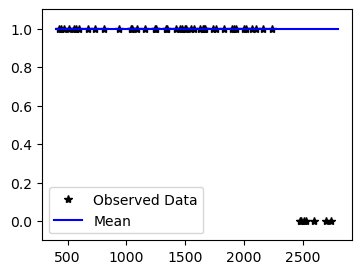

In [15]:
# Go into eval mode
model.eval()
likelihood.eval()

with torch.no_grad():
    # Test x are regularly spaced by 0.01 0,1 inclusive
    test_x = torch.linspace(400, 2800, 101)
    # Get classification predictions
    observed_pred = likelihood(model(test_x))
    print(observed_pred.mean.ge(0.1).float())

    # Initialize fig and axes for plot
    f, ax = plt.subplots(1, 1, figsize=(4, 3))
    ax.plot(train_x.numpy(), train_y.numpy(), 'k*')
    # Get the predicted labels (probabilites of belonging to the positive class)
    # Transform these probabilities to be 0/1 labels
    pred_labels = observed_pred.mean.ge(0.5).float()
    ax.plot(test_x.numpy(), pred_labels.numpy(), 'b')
    ax.set_ylim([-0.1, 1.1])
    ax.legend(['Observed Data', 'Mean'])

## Regression

In [ ]:
class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(ExactGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module =  gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())
    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

In [ ]:
likelihood = gpytorch.likelihoods.GaussianLikelihood()
model = ExactGPModel(train_x, train_y, likelihood)

In [ ]:
import os
smoke_test = ('CI' in os.environ)
training_iter = 2 if smoke_test else 50

model.train()
likelihood.train()

optimizer = torch.optim.Adam(model.parameters(), lr=0.1)

loss_ml = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

for i in range(training_iter):
    optimizer.zero_grad()
    output = model(train_x)
    loss = -loss_ml(output, train_y)
    loss.backward()
    print(f'Iteration: {i + 1}/{training_iter} \t Loss: {loss.item():.3f} \t Lengthscale: {model.covar_module.base_kernel.lengthscale.item():.3f} \t Noise:{model.likelihood.noise.item():.3f}')
    optimizer.step()

In [ ]:
model.eval()
likelihood.eval()

with torch.no_grad(), gpytorch.settings.fast_pred_var():
    test_x = torch.linspace(400, 2800, 101)
    observed_prediction = likelihood(model(test_x))

In [ ]:
with torch.no_grad():
    # Initialize plot
    f, ax = plt.subplots(1, 1)

    # Get upper and lower confidence bounds
    lower, upper = observed_prediction.confidence_region()
    # Plot training data as black stars
    ax.plot(train_x.numpy(), train_y.numpy(), 'k*')
    # Plot predictive means as blue line
    ax.plot(test_x.numpy(), observed_prediction.mean.numpy(), 'b')
    # Shade between the lower and upper confidence bounds
    ax.fill_between(test_x.numpy(), lower.numpy(), upper.numpy(), alpha=0.5)
    # ax.set_ylim([-0.5, 2])
    ax.legend(['Observed Data', 'Mean', 'Confidence'])
